In [1]:
import pandas as pd

path_energy = r'/Users/parvathykrishnank/Dropbox/modelling_and_simulation/Data/Energydata.xlsx'

# Energy consumption
df_energy =pd.read_excel(path_energy)
df_energy['Time'] = pd.to_datetime(df_energy['Time'], format="%d-%m-%Y %H:%M.%S")
df_energy['Energy(kWh)'] = df_energy['Energy kWh']
del df_energy['Energy kWh']

df_energy = df_energy[df_energy['Time']>='23-10-2017 00:00:00']
df_energy = df_energy.set_index('Time')

df_daily_mean = df_energy.resample('D').mean()
df_weekly_mean = df_daily_mean.resample('7D').mean()

In [2]:
df_energy['datetime1'] = df_energy.index

def getdailymean(r):
    temp = r['Energy(kWh)']
    index = r['datetime1']
    date_1 = index.date()
    baseline = df_daily_mean[df_daily_mean['datevalue']==date_1]['Energy(kWh)'].values[0]
    return baseline

df_daily_mean['datevalue'] = df_daily_mean.index
df_energy['daily_mean'] = df_energy.apply(getdailymean,axis=1)

In [3]:
def getweeklymean(r):
    temp = r['Energy(kWh)']
    index = r['datetime1']
    date_1 = index.date()
    week_data = df_weekly_mean[df_weekly_mean['datevalue']==date_1]
    
    if week_data.empty:
        week_data = df_weekly_mean[df_weekly_mean['datevalue']==(date_1-pd.DateOffset(3))]
        baseline = week_data['Energy(kWh)'].values[0]
        return baseline
    
    else: 
        baseline = week_data['Energy(kWh)'].values[0]
        return baseline

df_weekly_mean = df_weekly_mean.resample('D').ffill()
df_weekly_mean['datevalue'] = df_weekly_mean.index
df_energy['weekly_mean'] = df_energy.apply(getweeklymean,axis=1)
df_energy['Energy(daily_corr)'] = (df_energy['Energy(kWh)']-df_energy['daily_mean'])/df_energy['daily_mean']
df_energy['Energy(weekly_corr)'] = (df_energy['Energy(kWh)']-df_energy['weekly_mean'])/df_energy['weekly_mean']
df_energy['Energy(week_daily)'] = (df_energy['Energy(kWh)']-df_energy['daily_mean']-df_energy['weekly_mean'])
del df_energy['datetime1']

In [4]:
df = df_energy.resample('15T').mean()
df.head()

,Energy(kWh),daily_mean,weekly_mean,Energy(daily_corr),Energy(weekly_corr),Energy(week_daily)
Time,,,,,,
2017-10-23 19:30:00,9,8.444444,10.919147,0.065789,-0.175760,-10.363591
2017-10-23 19:45:00,10,8.444444,10.919147,0.184211,-0.084178,-9.363591
2017-10-23 20:00:00,9,8.444444,10.919147,0.065789,-0.175760,-10.363591
2017-10-23 20:15:00,8,8.444444,10.919147,-0.052632,-0.267342,-11.363591
2017-10-23 20:30:00,8,8.444444,10.919147,-0.052632,-0.267342,-11.363591


In [5]:
df['daily_mean'].describe()

count    13030.000000
mean        10.586646
std          2.139248
min          6.750000
25%          8.437500
50%         11.385417
75%         12.250000
max         14.583333
Name: daily_mean, dtype: float64

In [6]:
df['weekly_mean'].describe()

count    13030.000000
mean        10.548014
std          0.673507
min          8.177083
25%         10.313988
50%         10.657738
75%         11.002976
max         11.982171
Name: weekly_mean, dtype: float64

In [7]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# Create a trace
trace = go.Scatter(
    x = df.index,
    y = df['Energy(kWh)'],
    name = 'Energy'
)

trace1 = go.Scatter(
    x = df.index,
    y = df['daily_mean'],
    name = 'Daily average'
)

trace2 = go.Scatter(
    x = df.index,
    y = df['weekly_mean'],
    name = 'Weekly average'
)

data = [trace, trace1, trace2]

layout = go.Layout(
    title='Energy',
    xaxis=dict(
        title='Date',
    ),
    yaxis=dict(
        title='Energy (kWh)',
    )
)

fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
plot(fig, filename='Energy(kWh)')

/anaconda2/lib/python2.7/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `Energy(kWh)` didn't end with .html. Adding .html to the end of your file.



'file:///Users/parvathykrishnank/Dropbox/modelling_and_simulation/Energy(kWh).html'

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



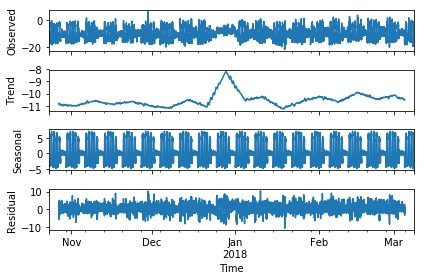

'file:///Users/parvathykrishnank/Dropbox/modelling_and_simulation/temp-plot.html'

In [8]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.offline import plot_mpl

result = seasonal_decompose(df['Energy(week_daily)'], freq=(24*60*7)/15,model='additive')
r1 = result.plot()
pyplot.show()
plot_mpl(r1)

In [9]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# Create a trace
trace = go.Scatter(
    x = df.index,
    y = df['Energy(week_daily)'],
    name = 'Energy'
)

data = [trace]

layout = go.Layout(
    title='Energy',
    xaxis=dict(
        title='Date',
    ),
    yaxis=dict(
        title='Energy (kWh)',
    )
)

fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
plot(fig, filename='Energy(kWh)')

'file:///Users/parvathykrishnank/Dropbox/modelling_and_simulation/Energy(kWh).html'

In [10]:
df_sub_lag = df['Energy(week_daily)'].diff(periods=1)
df_sub_lag = df_sub_lag.fillna(0)

In [11]:
df_sub_lag.head()

Time
2017-10-23 19:30:00    0.0
2017-10-23 19:45:00    1.0
2017-10-23 20:00:00   -1.0
2017-10-23 20:15:00   -1.0
2017-10-23 20:30:00    0.0
Freq: 15T, Name: Energy(week_daily), dtype: float64

In [12]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# Create a trace
trace = go.Scatter(
    x = df_sub_lag.index,
    y = df_sub_lag,
    name = 'Energy'
)


data = [trace]

layout = go.Layout(
    title='Energy',
    xaxis=dict(
        title='Date',
    ),
    yaxis=dict(
        title='Energy (kWh)',
    )
)

fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
plot(fig, filename='Energy(kWh)')

'file:///Users/parvathykrishnank/Dropbox/modelling_and_simulation/Energy(kWh).html'

In [13]:
path_ticketing = r'/Users/parvathykrishnank/Dropbox/modelling_and_simulation/Data/tickets.csv'
df_tickets =pd.read_csv(path_ticketing)

In [14]:
df_tickets['Time'] = pd.to_datetime(df_tickets['period ending'], format="%Y-%m-%d %H:%M:%S")
del df_tickets['period ending']

In [15]:
df_tickets = df_tickets[df_tickets['Time']>='2017-10-23 00:00:00']
df_tickets = df_tickets.set_index('Time')
df_tickets.head()

,visitors
Time,
2017-10-23 09:00:00,0
2017-10-23 09:08:00,0
2017-10-23 09:16:00,0
2017-10-23 09:24:00,0
2017-10-23 09:32:00,0


In [17]:
tickets_daily = df_tickets.resample('15T').ffill()

In [18]:
tickets_daily['corrected'] = tickets_daily - tickets_daily.mean()
tickets_daily.head()

,visitors,corrected
Time,,
2017-10-23 09:00:00,0,-3.14909
2017-10-23 09:15:00,0,-3.14909
2017-10-23 09:30:00,0,-3.14909
2017-10-23 09:45:00,0,-3.14909
2017-10-23 10:00:00,0,-3.14909


In [19]:
path_weather = r'/Users/parvathykrishnank/Dropbox/modelling_and_simulation/Data/Weather.xlsx'

# External Temperature
df_temperature =pd.read_excel(path_weather)
df_temperature['Time'] = pd.to_datetime(df_temperature['timestamp'], format="%d-%m-%Y %H:%M.%S")
del df_temperature['humidity']
df_temperature = df_temperature[df_temperature['timestamp']>='23-10-2017 00:00:00']
del df_temperature['timestamp']
df_temperature = df_temperature.set_index('Time')

In [20]:
temp_daily_mean = df_temperature.resample('D').mean()
temp_weekly_mean = temp_daily_mean.resample('7D').mean()

In [21]:
df_temperature['datetime1'] = df_temperature.index

def getdailymean(r):
    temp = r['temperature']
    index = r['datetime1']
    date_1 = index.date()
    baseline = temp_daily_mean[temp_daily_mean['datevalue']==date_1]['temperature'].values[0]
    return baseline

temp_daily_mean['datevalue'] = temp_daily_mean.index
df_temperature['daily_mean'] = df_temperature.apply(getdailymean,axis=1)

In [22]:
def getweeklymean(r):
    temp = r['temperature']
    index = r['datetime1']
    date_1 = index.date()
    week_data = temp_weekly_mean[temp_weekly_mean['datevalue']==date_1]
    if week_data.empty:
        week_data = temp_weekly_mean[temp_weekly_mean['datevalue']==(date_1-pd.DateOffset(3))]
        baseline = week_data['temperature'].values[0]
        return baseline
    
    else: 
        baseline = week_data['temperature'].values[0]
        return baseline

temp_weekly_mean = temp_weekly_mean.resample('D').ffill()
temp_weekly_mean['datevalue'] = temp_weekly_mean.index
df_temperature['weekly_mean'] = df_temperature.apply(getweeklymean,axis=1)
df_temperature['Temp(daily_corr)'] = df_temperature['temperature']-df_temperature['daily_mean']
df_temperature['Temp(weekly_corr)'] = (df_temperature['temperature']-df_temperature['weekly_mean'])/df_temperature['weekly_mean']
df_temperature['Temp(week_daily)'] = df_temperature['temperature']-df_temperature['daily_mean']-df_temperature['weekly_mean']
del df_temperature['datetime1']

In [23]:
df_temperature = df_temperature.resample('15T').ffill()

In [24]:
tem_lag = df_temperature['Temp(week_daily)'].diff(periods=1)
tem_lag = tem_lag.fillna(0)

In [25]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

trace = go.Scatter(
    x = df_sub_lag.index,
    y = df_sub_lag,
    name = 'Energy'
)

trace1 = go.Scatter(
    x = tickets_daily.index,
    y = tickets_daily['corrected'],
    name = 'Tickets',
    yaxis='y2'
)

trace2 = go.Scatter(
    x = tem_lag.index,
    y = tem_lag,
    name = 'Temperature',
    yaxis='y3'
)

data = [trace, trace1, trace2]

layout = go.Layout(
    title='Energy&Ticketing&Temperature',
    xaxis=dict(
        title='Date',
    ),
    yaxis=dict(
        title='Energy (kWh)',
    ),
    yaxis2=dict(
    overlaying = 'y',
    side = 'right'
    ),
    yaxis3=dict(
    overlaying = 'y',
    side = 'right'
    )
)

fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
plot(fig, filename='Energy(kWh)')

'file:///Users/parvathykrishnank/Dropbox/modelling_and_simulation/Energy(kWh).html'

In [26]:
df = pd.concat([df_sub_lag,tickets_daily,tem_lag],axis=1)
del df['visitors']
df['visitors'] = df['corrected']
del df['corrected']

In [27]:
correlation = df.corr()
correlation

,Energy(week_daily),Temp(week_daily),visitors
Energy(week_daily),1.000000,0.020550,0.015822
Temp(week_daily),0.020550,1.000000,0.048345
visitors,0.015822,0.048345,1.000000


In [28]:
print len(df)
p = 0
ind = 0

for i in range(0,len(df)):
    correlation = df['Energy(week_daily)'].corr(df['Temp(week_daily)'].shift(i))
    if(correlation>p):
        p = correlation
        ind = i
        
print p,ind

13074
0.623884706573 13066


/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning:

Degrees of freedom <= 0 for slice

/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning:

divide by zero encountered in double_scalars



In [29]:
p = 0
ind = 0

for i in range(0,len(df)):
    correlation = df['Energy(week_daily)'].corr(df['visitors'].shift(i))
    if(correlation>p):
        p = correlation
        ind = i
        
print p,ind

0.673110014078 13061


In [31]:
df['visitor_number'] = df['visitors'].shift(ind)

1.7 HOURS

In [34]:
df_shifted = df[['Energy(week_daily)','visitor_number']]
df_shifted.corr()

,Energy(week_daily),visitor_number
Energy(week_daily),1.00000,0.67311
visitor_number,0.67311,1.00000
